In [13]:
import pandas as pd
from utils.utility_functions import *
from Limma import batchEffectCorrection
from inmoose.pycombat import pycombat_norm

removing blanks
returning accepted signals


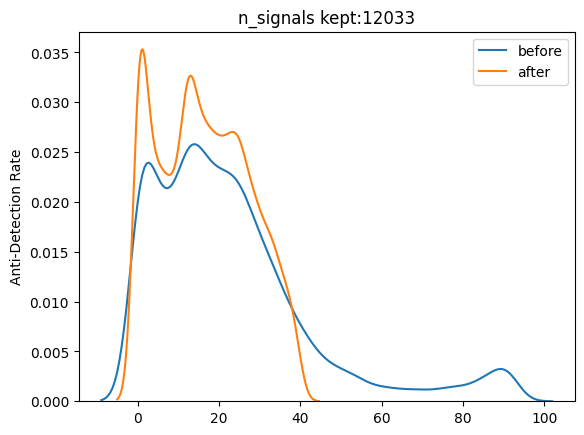

In [60]:
D = pd.read_csv("Data/2-peak_area_after_filling_missing_values.csv").set_index("position").drop(columns=['mz','rt','name']).T
M = pd.read_csv("Data/sample_metadata_all_batches.csv").set_index("sample_name")
D = D[~D.index.str.contains("_B_")]
M = M[~M.index.str.contains("_B_")]
D = D.drop(index='AOU_S_0104')
M = M.drop(index='AOU_S_0104')
D = D[detection(D,limit=0.40).index]
D = TIC(D,scale=True)
D = np.log2(D)

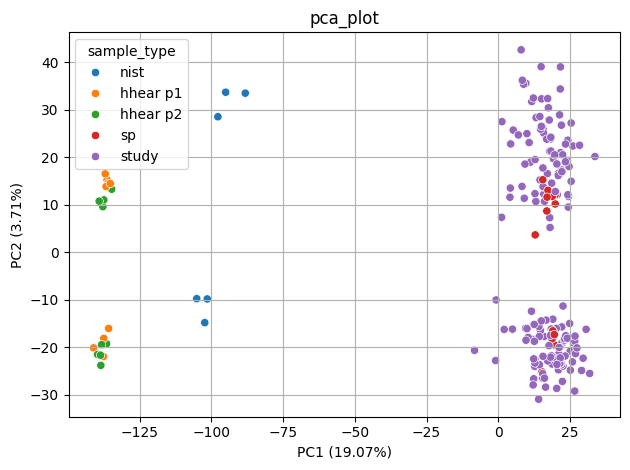

In [61]:
pca_plot(D,M)

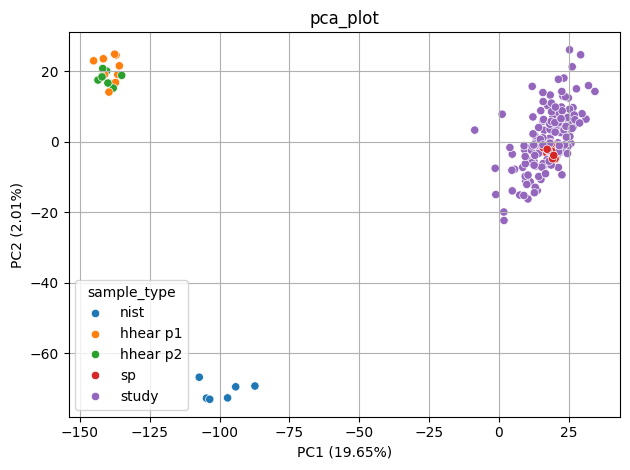

In [62]:
batch = M.loc[D.index,'batch']
combat = pycombat_norm(D.T,batch).T
pca_plot(combat,M)

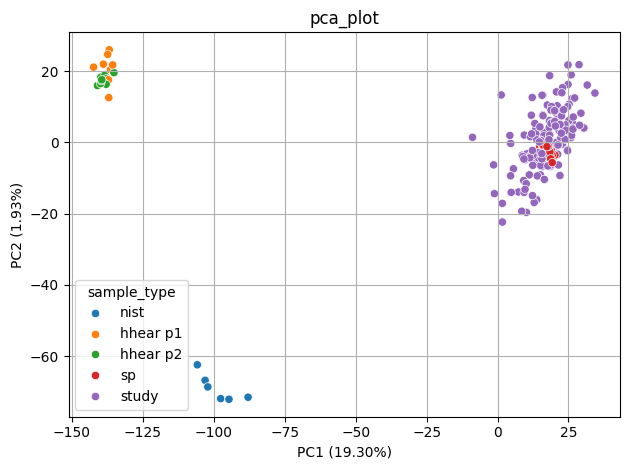

In [63]:
limma = batchEffectCorrection(D.T,M)
pca_plot(limma,M,hue='sample_type')

In [81]:
limmar = pd.read_csv("Data/limma_ref.csv").rename(columns={"Unnamed: 0":"name"}).set_index("name").T

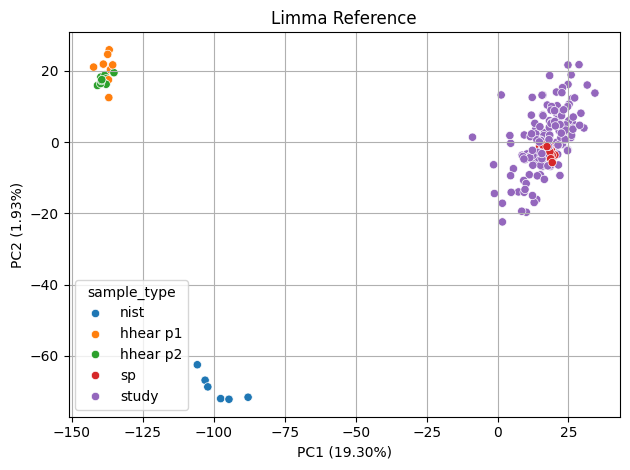

In [82]:
pca_plot(limmar,M,title='Limma Reference')